<a href="https://colab.research.google.com/github/mitrasurabhi/NLP-PROJECTS/blob/main/Word2Vec_Quora_question_pairs_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Identification of duplicate quora question pairs



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download("popular")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GlobalMaxPool1D, Input, GRU
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import gensim

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

#Reading data and basic stats

In [ ]:
dataset = pd.read_csv('https://cdn.extras.talentsprint.com/ADSMI/Datasets/quora_question_pairs.zip')
dataset

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
dataset.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [ ]:
dataset.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
dataset.duplicated().sum()

0

In [ ]:
dataset.drop(['id','qid1','qid2'],axis=1,inplace=True)

In [ ]:
dataset.isnull().sum()

question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
dataset.dropna(inplace= True)

In [ ]:
dataset.isnull().sum()

question1       0
question2       0
is_duplicate    0
dtype: int64

#Distribution of data points among output classes
* Number of duplicate (smilar) and non-duplicate (non similar) questions

# Cleaning

In [ ]:
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

In [ ]:
from bs4 import BeautifulSoup
def cleaning_text(text):
  # convert to lower case
    text = str(text).lower()
  # Replace certain special characters with their string equivalents
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
#text = re.sub(r'\b(\w+)[^\w\s]*\b', r'\1', text)
 #remove punctuations
    reg = re.compile('([^0-9A-Za-z t])|([.\/@#*<>?])')
    text=re.sub(reg,' ',text)
    # expanding the words in using contraction map
    new_text=[]
    for word in text.split():
        if word in CONTRACTION_MAP.keys():
            word=CONTRACTION_MAP[word]
        new_text.append(word)

    text = ' '.join(new_text)
    # Removing HTML tags
    text = BeautifulSoup(text)
    text = text.get_text()
    #remove stop words
    stop_words=set(stopwords.words('english'))
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    return text

In [ ]:
quora = pd.DataFrame()
quora['clean_ques1']=dataset.question1.apply(cleaning_text)
quora['clean_ques2']=dataset.question2.apply(cleaning_text)

In [ ]:
print(quora.shape)
quora.isna().sum()

(404287, 2)


clean_ques1    0
clean_ques2    0
dtype: int64

In [ ]:
# Train the word2vec model
#from gensim.models import Word2Vec
sentence1 = [str(sentence).split() for sentence in quora['clean_ques1']]
sentence2 = [str(sentence).split() for sentence in quora['clean_ques2']]
sentence = sentence1 + sentence2
#sentence1[:20]
w2v_model = gensim.models.Word2Vec(sentence,vector_size=100,window=5,min_count=1)

In [ ]:
print(sentence[:20])
print(type(sentence))
print(len(sentence))

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'], ['story', 'kohinoor', 'koh', 'noor', 'diamond'], ['increase', 'speed', 'internet', 'connection', 'using', 'vpn'], ['mentally', 'lonely', 'solve'], ['one', 'dissolve', 'water', 'quikly', 'sugar', 'salt', 'methane', 'carbon', 'di', 'oxide'], ['astrology', 'capricorn', 'sun', 'cap', 'moon', 'cap', 'rising', 'say'], ['buy', 'tiago'], ['good', 'geologist'], ['use', 'instead'], ['motorola', 'company', 'hack', 'charter', 'motorolla', 'dcx3400'], ['method', 'find', 'separation', 'slit', 'using', 'fresnel', 'biprism'], ['read', 'find', 'youtube', 'comment'], ['make', 'physic', 'easy', 'learn'], ['first', 'sexual', 'experience', 'like'], ['law', 'change', 'status', 'student', 'visa', 'green', 'card', 'u', 'compare', 'immigration', 'law', 'canada'], ['would', 'trump', 'presidency', 'mean', 'current', 'international', 'master', 'student', 'f1', 'visa'], ['manipulation', 'mean'], ['girl', 'want', 'friend', 'guy', 'reject'], ['many', 

In [ ]:
# Returns all of the words that appeared in the training data at least twice
#w2v_model.wv.index_to_key

In [ ]:
w2v_model.wv.most_similar('country')

[('usa', 0.6599264740943909),
 ('china', 0.6552101969718933),
 ('u', 0.6476272940635681),
 ('europe', 0.6378780007362366),
 ('nation', 0.6332923173904419),
 ('uk', 0.6282986998558044),
 ('canada', 0.6038807034492493),
 ('european', 0.5937619209289551),
 ('germany', 0.5873174667358398),
 ('america', 0.5823152661323547)]

In [ ]:
quora

,clean_ques1,clean_ques2
0,step step guide invest share market india,step step guide invest share market
1,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,increase speed internet connection using vpn,internet speed increased hacking dns
3,mentally lonely solve,find remainder math 23 24 math divided 24 23
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water
...,...,...
404285,many keywords racket programming language late...,many keywords perl programming language latest...
404286,believe life death,true life death
404287,one coin,coin
404288,approx annual cost living studying uic chicago...,little hairfall problem want use hair styling ...


In [ ]:
def vectorize(sentence):

    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return [0,0,0]
    else:
        words_vecs = np.array(words_vecs)
        mean = np.mean(words_vecs)
        max = np.max(words_vecs)
        s_dev = np.std(words_vecs)
        matrix =[mean,max,s_dev]
        return matrix

In [ ]:
%%capture
mvec1 =[vectorize(str(sentence)) for sentence in quora['clean_ques1']]
mvec2 =[vectorize(str(sentence)) for sentence in quora['clean_ques2']]

In [ ]:
mvec2[:10]

[[-0.0051325737, 4.7553835, 1.1091677],
 [-0.031472564, 3.9654427, 0.947091],
 [0.0136001455, 4.296773, 0.9236643],
 [0.0398254, 3.6163757, 1.0142993],
 [0.019904548, 3.95153, 1.0652919],
 [0.037007947, 3.2627175, 0.78030556],
 [0.0048228605, 4.4036756, 1.1413445],
 [0.0194254, 1.9489518, 0.67471415],
 [0.032034352, 3.3797626, 1.0163584],
 [-0.013064377, 3.120195, 0.9287545]]

In [ ]:
df1 = pd.DataFrame(mvec1,index = quora.index,columns= ['np_mean1','np_max1','np_sdev1'])
df1

,np_mean1,np_max1,np_sdev1
0,0.000578,4.755383,1.112135
1,-0.032686,2.257829,0.560091
2,0.003926,4.296773,1.110729
3,0.012606,3.302940,0.805760
4,0.025703,3.951530,0.754999
...,...,...,...
404285,-0.040875,5.091415,1.108952
404286,0.064426,3.037858,1.206777
404287,0.001542,2.492234,0.959265
404288,0.002752,3.965443,1.039506


In [ ]:
df2 = pd.DataFrame(mvec2,index = quora.index,columns= ['np_mean2','np_max2','np_sdev2'])
df2

,np_mean2,np_max2,np_sdev2
0,-0.005133,4.755383,1.109168
1,-0.031473,3.965443,0.947091
2,0.013600,4.296773,0.923664
3,0.039825,3.616376,1.014299
4,0.019905,3.951530,1.065292
...,...,...,...
404285,-0.037928,5.091415,1.107216
404286,0.072170,3.037858,1.139187
404287,-0.051143,2.268003,0.936153
404288,0.051839,3.441447,0.952073


In [ ]:
def np_vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
%%capture
vec1 = [np_vectorize(str(sentence)) for sentence in quora['clean_ques1']]
vec2 = [np_vectorize(str(sentence)) for sentence in quora['clean_ques2']]

In [ ]:
temp_df1 = pd.DataFrame(vec1,index=quora.index)
temp_df2 = pd.DataFrame(vec2,index=quora.index)
print(temp_df1.head())
print(temp_df2.head())


         0         1         2         3         4         5         6   \
0  0.038798  0.717556 -0.547127 -0.279182  0.587376  0.271549  0.437097   
1  0.314213  0.331498  0.229546 -0.258296  0.230136 -0.242527  0.303510   
2 -0.946713 -0.125440  0.574405  0.313725 -0.297812  0.530288 -0.095012   
3 -0.030368 -0.029589 -0.243564 -0.196974 -0.188907  0.254977  0.311459   
4 -0.275200  0.495546  0.095934  0.083510 -0.053656 -0.447153 -0.093474   

         7         8         9   ...        90        91        92        93  \
0 -0.148573  0.202758  0.163887  ... -0.078344 -0.410082  0.977331  0.882488   
1  0.577362  0.262574  0.091331  ...  0.325321  0.070160  0.391909  0.203539   
2 -0.699091 -0.285327  1.081079  ...  0.350346  1.062371 -0.863567  0.929075   
3  0.209171 -0.110029 -0.581827  ...  0.114630  0.582214 -0.073479  0.263651   
4  0.590240 -0.322908  0.453425  ...  0.264770  0.198744 -0.134297 -0.024593   

         94        95        96        97        98        99  
0  0

New Code using 100 vector representation

In [ ]:
quora['q1_len'] = quora['clean_ques1'].str.len()
quora['q2_len'] = quora['clean_ques2'].str.len()

In [ ]:
quora['q1_num_words'] = quora['clean_ques1'].apply(lambda row: len(row.split(" ")))
quora['q2_num_words'] = quora['clean_ques2'].apply(lambda row: len(row.split(" ")))

In [ ]:
def common_words(row):
     w1 = set(map(lambda word: word.lower().strip(), row['clean_ques1'].split(" ")))
     w2 = set(map(lambda word: word.lower().strip(), row['clean_ques2'].split(" ")))
     return len(w1 & w2)

In [ ]:
quora['word_common'] = quora.apply(common_words, axis=1)

In [ ]:
def total_words(row):
     w1 = set(map(lambda word: word.lower().strip(), row['clean_ques1'].split(" ")))
     w2 = set(map(lambda word: word.lower().strip(), row['clean_ques2'].split(" ")))
     return (len(w1) + len(w2))

In [ ]:
quora['word_total'] = quora.apply(total_words, axis=1)

In [ ]:
quora['word_share'] = round(quora['word_common']/quora['word_total'],2)

In [ ]:
quora.drop(columns = ['clean_ques1','clean_ques2'],inplace = True)

In [ ]:
quora

,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
0,41,35,7,6,5,11,0.45
1,31,67,5,10,4,15,0.27
2,44,36,6,5,2,11,0.18
3,21,44,3,9,0,9,0.00
4,60,29,10,5,2,15,0.13
...,...,...,...,...,...,...,...
404285,56,54,7,7,6,14,0.43
404286,18,15,3,3,2,6,0.33
404287,8,4,2,1,1,3,0.33
404288,61,77,9,13,0,22,0.00


In [ ]:
final_df = pd.concat([quora,df1,df2,temp_df1,temp_df2], axis=1)

In [ ]:
final_df.dtypes

q1_len            int64
q2_len            int64
q1_num_words      int64
q2_num_words      int64
word_common       int64
                 ...   
95              float64
96              float64
97              float64
98              float64
99              float64
Length: 213, dtype: object

In [ ]:
final_df.columns = final_df.columns.astype(str)
# quora['num_ques1'] = pd.to_numeric(quora['num_ques1'])
# quora['num_ques2'] = pd.to_numeric(quora['num_ques2'])

In [ ]:
final_df

,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,np_mean1,np_max1,np_sdev1,...,90,91,92,93,94,95,96,97,98,99
0,41,35,7,6,5,11,0.45,0.000578,4.755383,1.112135,...,0.299953,-0.403481,1.067288,0.812995,0.608848,1.194738,-0.929530,0.636571,0.060470,-0.284853
1,31,67,5,10,4,15,0.27,-0.032686,2.257829,0.560091,...,-0.162934,0.074871,0.538224,0.956488,-0.178107,0.618794,-0.323711,0.018381,0.128659,0.026985
2,44,36,6,5,2,11,0.18,0.003926,4.296773,1.110729,...,0.064437,0.536212,-0.326976,0.576991,-0.324447,1.337669,0.295700,1.012254,0.647503,-0.425248
3,21,44,3,9,0,9,0.00,0.012606,3.302940,0.805760,...,0.442791,0.551145,0.305583,1.198292,0.665051,0.276205,-0.730551,0.699930,-0.391388,0.647760
4,60,29,10,5,2,15,0.13,0.025703,3.951530,0.754999,...,-0.068765,0.132721,0.100048,0.100123,-0.459255,1.484291,0.159626,-0.412202,0.605216,0.174764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,56,54,7,7,6,14,0.43,-0.040875,5.091415,1.108952,...,-0.537482,0.371346,-0.490136,0.427957,1.262882,0.722708,0.825303,0.121356,0.298591,0.131396
404286,18,15,3,3,2,6,0.33,0.064426,3.037858,1.206777,...,0.895260,-0.376621,0.423400,0.973644,0.420917,0.001440,-0.788350,0.223743,-0.424428,-0.289914
404287,8,4,2,1,1,3,0.33,0.001542,2.492234,0.959265,...,0.132058,1.292859,0.253462,1.202731,-0.806353,0.110541,-0.432854,1.889128,-0.980406,1.583582
404288,61,77,9,13,0,22,0.00,0.002752,3.965443,1.039506,...,0.065122,0.260731,-0.128992,0.051847,1.368363,0.607619,-0.037542,0.181794,0.086620,0.151035


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

# Define the columns to be scaled
#columns_to_scale = ['q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'word_common', 'word_total', 'word_share']
scaled_data = scaler.fit_transform(final_df)


In [ ]:
# # Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_df, dataset['is_duplicate'], test_size=0.3, random_state=428)

In [ ]:
# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(283000, 213)
(283000,)
(121287, 213)
(121287,)


Different Classification models

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [ ]:
def cm_disp(confusion_matrix):
  cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
  cm_display.plot()
  plt.show()

In [ ]:
#Train a classification model : Word to Vec
from sklearn.linear_model import LogisticRegression

logisticModel = LogisticRegression(solver='liblinear', penalty='l1')
logisticModel.fit(X_train,y_train)
#Logistic regression Confusion Matrix
y_pred = logisticModel.predict(X_test)

print("Logistic regression confusion matrix")
logistic_confusionMatrix = confusion_matrix(y_test, y_pred)
print(logistic_confusionMatrix)
print( 'test_accuracy = ', accuracy_score(y_test, y_pred))

# Predict labels for the training data
y_train_pred = logisticModel.predict(X_train)
# Calculate train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

print("\nClassification report for logistic regression model")
print(classification_report(y_test, y_pred))

Logistic regression confusion matrix
[[63190 13203]
 [18194 26700]]
test_accuracy =  0.7411346640612761
Train Accuracy: 0.7416819787985865

Classification report for logistic regression model
              precision    recall  f1-score   support

           0       0.78      0.83      0.80     76393
           1       0.67      0.59      0.63     44894

    accuracy                           0.74    121287
   macro avg       0.72      0.71      0.72    121287
weighted avg       0.74      0.74      0.74    121287



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = range(1, len(train_accuracy) + 1)
# Plot the graph
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, accuracy_score(y_test, y_pred), 'r', label='Testing Accuracy')
# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

# Set y-axis limits
plt.ylim([0, 1])

# Show the plot
plt.show()


TypeError: ignored

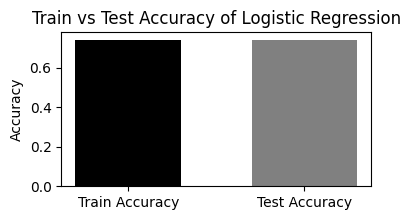

In [ ]:
labels = ['Train Accuracy', 'Test Accuracy']
accuracies = [train_accuracy, accuracy_score(y_test, y_pred)]
colors = ['black', 'grey']
plt.figure(figsize=(4, 2))
plt.bar(labels, accuracies, color=colors,width=0.6)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy of Logistic Regression')
plt.show()

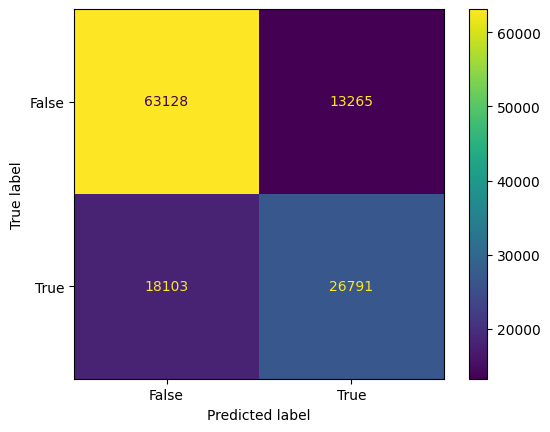

In [ ]:
cm_disp(logistic_confusionMatrix)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
randomForestModel =  RandomForestClassifier()
randomForestModel.fit(X_train,y_train)
randomForestModel.classes_
#RandomForest Confusion Matrix #word to vec
y_pred_rf = randomForestModel.predict(X_test)
print("RandomForest confusion matrix")
randomForestModel_confusionMatrix = confusion_matrix(y_test, y_pred_rf)
print(randomForestModel_confusionMatrix)
print( 'test_accuracy = ', accuracy_score(y_test, y_pred_rf))

# Predict labels for the training data
y_train_pred_rf = randomForestModel.predict(X_train)
# Calculate train accuracy
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print("Train Accuracy:", train_accuracy_rf)

print("\nClassification report for random forest model")
print(classification_report(y_test, y_pred_rf))

RandomForest confusion matrix
[[68771  7622]
 [13671 31223]]
test_accuracy =  0.8244412014478056
Train Accuracy: 0.9970388692579505

Classification report for random forest model
              precision    recall  f1-score   support

           0       0.83      0.90      0.87     76393
           1       0.80      0.70      0.75     44894

    accuracy                           0.82    121287
   macro avg       0.82      0.80      0.81    121287
weighted avg       0.82      0.82      0.82    121287



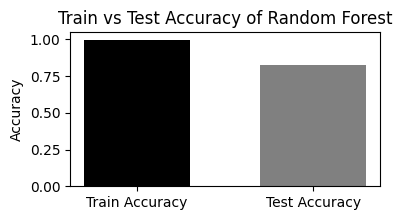

In [ ]:
labels = ['Train Accuracy', 'Test Accuracy']
accuracies = [train_accuracy_rf, accuracy_score(y_test, y_pred_rf)]
colors = ['black', 'grey']
plt.figure(figsize=(4, 2))
plt.bar(labels, accuracies, color=colors,width=0.6)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy of Random Forest')
plt.show()

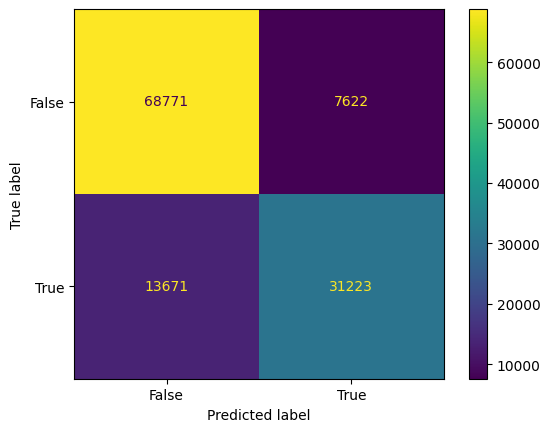

In [ ]:
cm_disp(randomForestModel_confusionMatrix)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
decisionTreeModel = DecisionTreeClassifier()
decisionTreeModel.fit(X_train, y_train)
randomForestModel.classes_

#Decision tree Confusion Matrix # word to vec
y_pred_dt = decisionTreeModel.predict(X_test)
print("Decision tree confusion matrix")
decisionTreeModel_confusionMatrix = confusion_matrix(y_test,y_pred_dt )
print(decisionTreeModel_confusionMatrix)
print( 'test_accuracy = ', accuracy_score(y_test, y_pred_dt))

# Predict labels for the training data
y_train_pred_dt = decisionTreeModel.predict(X_train)
# Calculate train accuracy
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
print("Train Accuracy:", train_accuracy_dt)

print("Classification report for decision tree model")
print(classification_report(y_test, y_pred_dt))

Decision tree confusion matrix
[[60733 15660]
 [14671 30223]]
test_accuracy =  0.7499237346129428
Train Accuracy: 0.9970388692579505
Classification report for decision tree model
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     76393
           1       0.66      0.67      0.67     44894

    accuracy                           0.75    121287
   macro avg       0.73      0.73      0.73    121287
weighted avg       0.75      0.75      0.75    121287



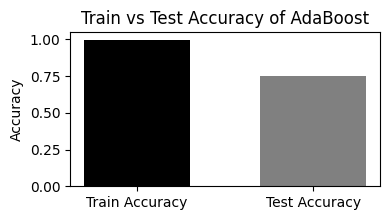

In [ ]:
labels = ['Train Accuracy', 'Test Accuracy']
accuracies = [train_accuracy_dt, accuracy_score(y_test, y_pred_dt)]
colors = ['black', 'grey']
plt.figure(figsize=(4, 2))
plt.bar(labels, accuracies, color=colors,width=0.6)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy of AdaBoost')
plt.show()

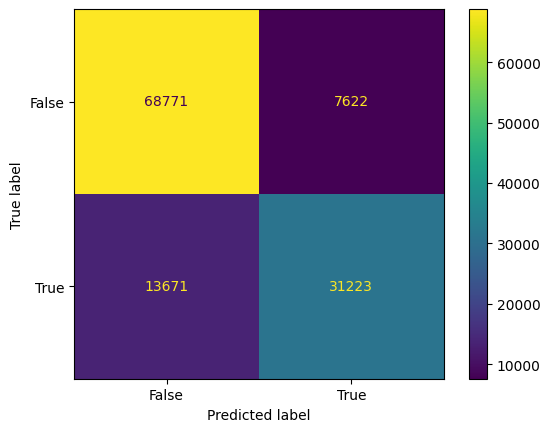

In [ ]:
cm_disp(randomForestModel_confusionMatrix)

In [ ]:
# Adaboost #word to vec
from sklearn.ensemble import AdaBoostClassifier

# Choosing Decision Tree with 1 level as the weak learner
DTC=DecisionTreeClassifier(max_depth=6)
clf = AdaBoostClassifier(n_estimators=50, base_estimator=DTC ,learning_rate=0.01)

# Creating the model on Training Data
AB=clf.fit(X_train,y_train)
y_pred_clf=AB.predict(X_test)

# Measuring accuracy on Testing Data
print(classification_report(y_test, y_pred_clf))
print(confusion_matrix(y_test, y_pred_clf))
# Printing the Overall Accuracy of the model
print( 'test_accuracy = ', accuracy_score(y_test, y_pred_clf))

# Predict labels for the training data
y_train_pred_clf = AB.predict(X_train)
# Calculate train accuracy
train_accuracy_clf = accuracy_score(y_train, y_train_pred_clf)
print("Train Accuracy:", train_accuracy_clf)

              precision    recall  f1-score   support

           0       0.77      0.85      0.81     76393
           1       0.68      0.56      0.62     44894

    accuracy                           0.74    121287
   macro avg       0.73      0.70      0.71    121287
weighted avg       0.74      0.74      0.73    121287

[[64822 11571]
 [19818 25076]]
test_accuracy =  0.7412006233149472
Train Accuracy: 0.747452296819788


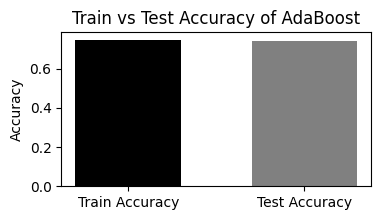

In [ ]:
labels = ['Train Accuracy', 'Test Accuracy']
accuracies = [train_accuracy_clf, accuracy_score(y_test, y_pred_clf)]
colors = ['black', 'grey']
plt.figure(figsize=(4, 2))
plt.bar(labels, accuracies, color=colors,width=0.6)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy of AdaBoost')
plt.show()

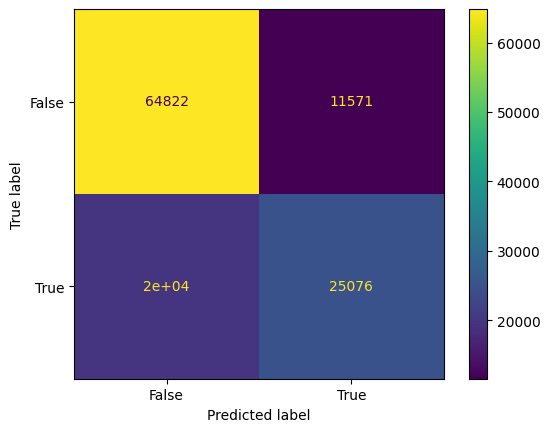

In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred_clf)
cm_disp(confusion_matrix)